# PyGlove 2D Augmentation Tutorial 

This notebook shows how to create and call PyGlove 2D Augmentation policies.

Here are the **pre-requisites** before you can start using this notebook: 
1. The **environment** for this *notebook-instance* is set to TensorFlow:1.15.
2. You have selected a python3 kernel to run this notebook.

# Install libraries

The following libraries installation needs to be run just once. 

In [1]:
%%sh
pip3 install scikit-image==0.18.3 --user

# Download the code from Cloud Repository
**NOTE:** The following set up steps need to be done just once.



In [ ]:
%%sh

# NOTE: It is ok for this step to fail if the directory exists.
mkdir -p ~/nas_experiment

In [ ]:
%%sh

rm -r -f ~/nas_experiment/nas_codes
git clone https://github.com/google/vertex-ai-nas.git ~/nas_experiment/nas_codes

# Set code path

In [4]:
import os
os.chdir('/home/jupyter/nas_experiment/nas_codes')

# Stand-alone 2D Augmentation Policy examples

In [5]:
# Define plotting functions

import matplotlib
import matplotlib.pyplot as plt
from nas_lib.augmentation_2d import policies
import tensorflow as tf

def plot_image_and_boxes(ax, image, boxes):
  height, width = image.shape[:2]
  boxes_scaled = boxes * np.array([height, width, height, width])
  ax.imshow(image)
  for min_y, min_x, max_y, max_x in boxes_scaled:
    width = max_x - min_x
    height = max_y - min_y
    patch = matplotlib.patches.Rectangle([min_x, min_y],
                                         width, height,
                                         linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(patch)


def plot_image_and_augs(image, augs):
  num_augs = len(augs)
  _, ax = plt.subplots(1, 1+num_augs, figsize=(10, 10))
  ax[0].imshow(image)
  ax[0].set_title('Image')
  for i, aug in enumerate(augs, start=1):
    ax[i].imshow(aug)
    ax[i].set_title('Aug #{}'.format(i))


def plot_image_and_bbox_augs(image, bboxes, augs, aug_bboxes):
  num_augs = len(augs)
  _, ax = plt.subplots(1, 1+num_augs, figsize=(10, 10))
  ax[0].imshow(image)
  plot_image_and_boxes(ax[0], image, bboxes)
  ax[0].set_title('Image')
  for i, (aug, aug_bbox) in enumerate(zip(augs, aug_bboxes), start=1):
    plot_image_and_boxes(ax[i], aug, aug_bbox)
    ax[i].set_title('Aug #{}'.format(i))

Text(0.5, 1.0, 'Segmentation Mask')

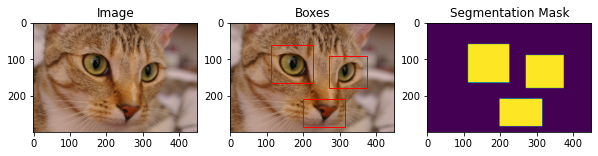

In [6]:
# Get a Sample Image and Ground Truth: Using fake ground-truth.

from skimage import data
import numpy as np

# A random numpy image
image = data.chelsea()

# Create Fake Bounding Boxes as [(min_y, min_x, max_y, max_x), ...]
boxes = np.array([[0.2, 0.25, 0.55, 0.5],
                  [0.3, 0.6, 0.6, 0.83],
                  [0.7, 0.44, 0.95, 0.7],
                  ], dtype=np.float32)

# Create Fake Segmentation Mask
sy, sx = image.shape[0:2]
segmentation_mask = np.zeros((image.shape[:2]), dtype=np.uint8)
for box in boxes:
    miny, minx, maxy, maxx = box[:]
    miny = int(miny*sy)
    maxy = int(maxy*sy)
    minx = int(minx*sx)
    maxx = int(maxx*sx)
    segmentation_mask[miny:maxy, minx:maxx] = 1

# Show image and fake ground truth
_, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(image)
ax[0].set_title('Image')
plot_image_and_boxes(ax[1], image, boxes)
ax[1].set_title('Boxes')
ax[2].imshow(segmentation_mask)
ax[2].set_title('Segmentation Mask')

## Single Op Policy example

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



2021-11-04 18:53:52.510225: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2021-11-04 18:53:52.510828: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55d90f438c50 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-11-04 18:53:52.510862: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-11-04 18:53:52.511970: I tensorflow/core/common_runtime/process_util.cc:136] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


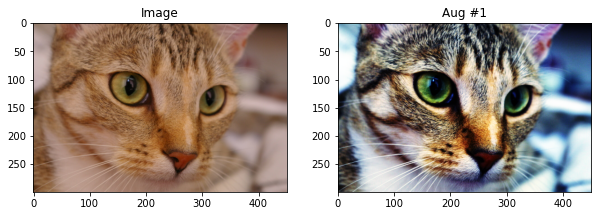

In [7]:
# Classification

p = policies.Equalize()
aug_image = p(image)
with tf.Session() as sess:
  aug_image = sess.run(aug_image)
plot_image_and_augs(image, [aug_image])

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.


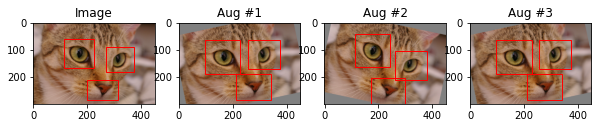

In [8]:
# Detection

p = policies.Rotate(magnitude=4)
num_augs = 3
aug_images = []
aug_bbs = []
for _ in range(num_augs):
  aug_image, aug_bb = p(image, bounding_boxes=boxes)
  with tf.Session() as sess:
    aug_image, aug_bb = sess.run([aug_image, aug_bb])
  aug_images.append(aug_image)
  aug_bbs.append(aug_bb)
plot_image_and_bbox_augs(image, boxes, aug_images, aug_bbs)

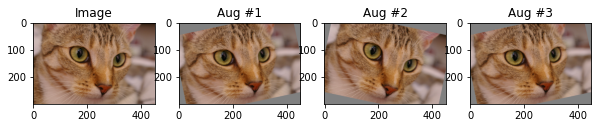

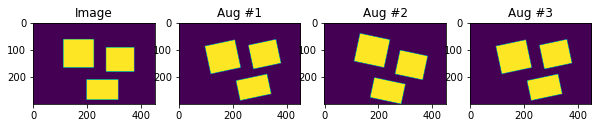

In [9]:
# Segmentation
p = policies.Rotate(magnitude=4, mask_replace=0)
num_augs = 3
aug_images = []
aug_masks = []
for _ in range(num_augs):
  aug_image, aug_mask = p(image, segmentation_mask=segmentation_mask)
  with tf.Session() as sess:
    aug_image, aug_mask = sess.run([aug_image, aug_mask])
  aug_images.append(aug_image)
  aug_masks.append(aug_mask)
plot_image_and_augs(image, aug_images)
plot_image_and_augs(segmentation_mask, aug_masks)

## Multi Op Policy example

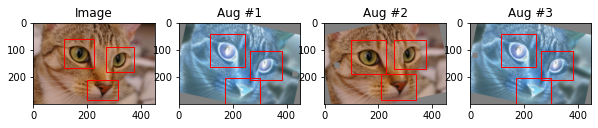

In [10]:
p = policies.Sequential([
                         policies.ApplyWithProbability(policies.Invert(), 0.5),
                         policies.Rotate(magnitude=4),
                         policies.CutoutImage(magnitude=1)
])
num_augs = 3
aug_images = []
aug_bbs = []
for _ in range(num_augs):
  aug_image, aug_bb = p(image, bounding_boxes=boxes)
  with tf.Session() as sess:
    aug_image, aug_bb = sess.run([aug_image, aug_bb])
  aug_images.append(aug_image)
  aug_bbs.append(aug_bb)
plot_image_and_bbox_augs(image, boxes, aug_images, aug_bbs)

## RandAugment Policy example

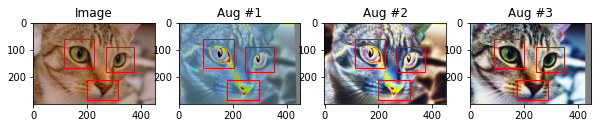

In [11]:
# 'num_ops' controls the number of successive augmentation operations and the 'magnitude' controls the degree of these augmentations.
p_functor = policies.randaugment_detection_policy(num_ops=4, magnitude=1)
p = p_functor()
num_augs = 3
aug_images = []
aug_bbs = []
for _ in range(num_augs):
  aug_image, aug_bb = p(image, bounding_boxes=boxes)
  with tf.Session() as sess:
    aug_image, aug_bb = sess.run([aug_image, aug_bb])
  aug_images.append(aug_image)
  aug_bbs.append(aug_bb)
plot_image_and_bbox_augs(image, boxes, aug_images, aug_bbs)

# How 2D Augmentation Policy works with NAS

## NAS services samples search-space to generate nas_params_str

In [12]:
import json
import pyglove as pg
import search_spaces

# An example of 2D policy-spec sampled by NAS service from 
# "randaugment_detection" search-space in search_spaces.py file.
def get_nas_trial_param_str(search_space):
  """Returns JSON string value for nas trial param."""
  nodes_builder = search_spaces.get_search_space(search_space)
  pg_search_space = pg.search_space(nodes_builder)

  algorithm = pg.geno.Random()
  algorithm.setup(pg_search_space)
  one_model_dna = algorithm.propose()
  one_model_dna.use_spec(pg_search_space)
  return json.dumps(one_model_dna.parameters(use_literal_values=True))

nas_params_str = get_nas_trial_param_str("randaugment_detection")
print("Example of policy-spec passed to trainer-docker by the NAS-service as --nas_params_str flag:")
print(nas_params_str)

Example of policy-spec passed to trainer-docker by the NAS-service as --nas_params_str flag:
{"num_ops": "0/2 (1)", "magnitude": "3/10 (4)"}


Note: If you want to change the `num_ops` and `magnitude` for `randaugment_detection`, you can change it [here](https://source.cloud.google.com/cloud-nas-260507/nas-codes-release/+/master:search_spaces.py;l=145).

If you want to modify the Augmentation policies like removing `TranslateY`, you can directly modify the function `randaugment_detection_policy` in `policies.py` file.

## Trainer container consumes nas_params_str from NAS-service to generate augmentation policy

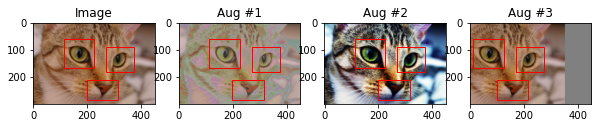

In [13]:
# An example of how to consume the policy-spec "nas_params_str" inside the trainer to augment the features.
nas_params_dict = json.loads(nas_params_str)
policy_spec = pg.materialize(search_spaces.get_search_space("randaugment_detection"), nas_params_dict)
p = policies.get_policy_from_str(pg.to_json_str(policy_spec))

# Apply augmetation policy to features.
num_augs = 3
aug_images = []
aug_bbs = []
for _ in range(num_augs):
  aug_image, aug_bb = p(image, bounding_boxes=boxes)
  with tf.Session() as sess:
    aug_image, aug_bb = sess.run([aug_image, aug_bb])
  aug_images.append(aug_image)
  aug_bbs.append(aug_bb)
plot_image_and_bbox_augs(image, boxes, aug_images, aug_bbs)